# Getting started with ODE Test Problems

## About this notebook

This Jupyter notebook is configured to run [Octave](https://octave.org/) commands. Press `Shift + Enter` To run each cell and go the next. 
The latest version of `ODE-Test-Problems (OTP)` is automatically pulled from its [Github repository](https://github.com/ComputationalScienceLaboratory/ODE-Test-Problems.git). We just need to add the package to the path:

In [1]:
addpath(genpath('../../ODE-Test-Problems'))

In [2]:
graphics_toolkit("plotly")
displayformat matrix latex

## Lorenz63 test problem 

The Lorenz63 test problem, introduced by mathematician Edward Lorenz in 1963 to study the behavior of a simple system of differential equations, is a classic problem in chaos theory. It consists of three ordinary differential equations that describe the behavior of a simplified atmospheric convection system. The following are the equations:

\begin{align}
\frac{dx}{dt} &= σ(y - x), \\
\frac{dy}{dt} &= x(ρ - z) - y, \\
\frac{dz}{dt} &= xy - βz.
\end{align}
where $x$, $y$, and $z$ are variables that represent the state of the system at a given time, and σ, ρ, and β are parameters that control the behavior of the system.

This test problem exhibits chaotic behavior, meaning that small changes in initial conditions can lead to drastic changes over time. The [butterfly effect](https://en.wikipedia.org/wiki/Butterfly_effect), or sensitive dependence on initial conditions, defines chaotic systems. The Lorenz63 test problem is widely used to test numerical methods for solving differential equations and chaotic physical and biological systems.

Let's create the Lorenz63 problem and solve it using the default parameters and intial conditions:

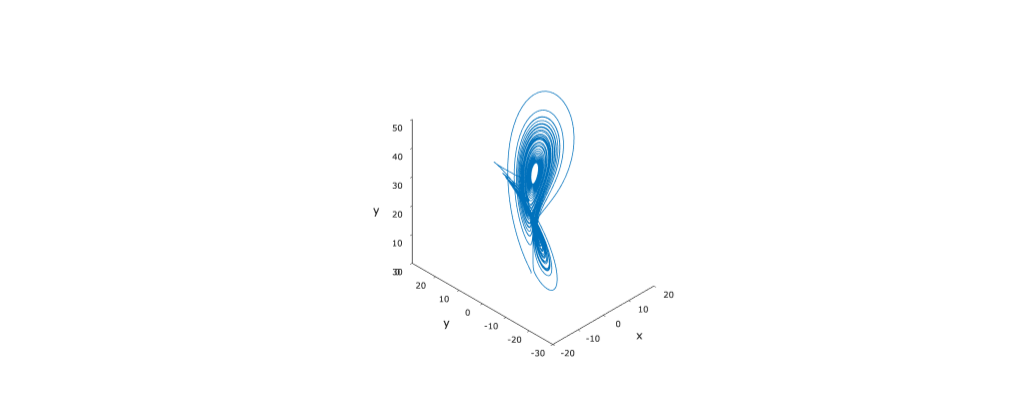

In [3]:
% Create a problem object
problem = otp.lorenz63.presets.Canonical;

% Solve the problem
sol = problem.solve('RelTol', 1e-10);

% Plot the solution
problem.plotPhaseSpace(sol);

The `problem` object contains a number of useful properties including:

* `Name`: The name of the problem
* `NumVars`:Number of variables in the state vector
* `Parameters`:Vector of problem-specific parameters that can be modified 
* `RHS` : The Right-hand-side structure inlcludes the ODE right-hand-side functions and possibly Jacobians, splittings, etc. (depending on the test problem)
* `TimeSpan`:TimeSpan for the solution
* `Y0`:Initial condition 


In [4]:
problem

problem =   otp.lorenz63.presets.Canonical object with properties:

            Name: Lorenz Equations
         NumVars: [1x1 double]
      Parameters: [1x1 otp.lorenz63.Lorenz63Parameters]
             RHS: [1x1 otp.RHS]
        TimeSpan: [2x1 double]
              Y0: [3x1 double]


In [5]:
problem.TimeSpan

ans =     0
   60


## Plotting solutions 

`OTP` has built-in plotting capabilities for visualizing the computed problem solution.  For small problems it is possible to plot the solution trajectory using the `plot` function. 

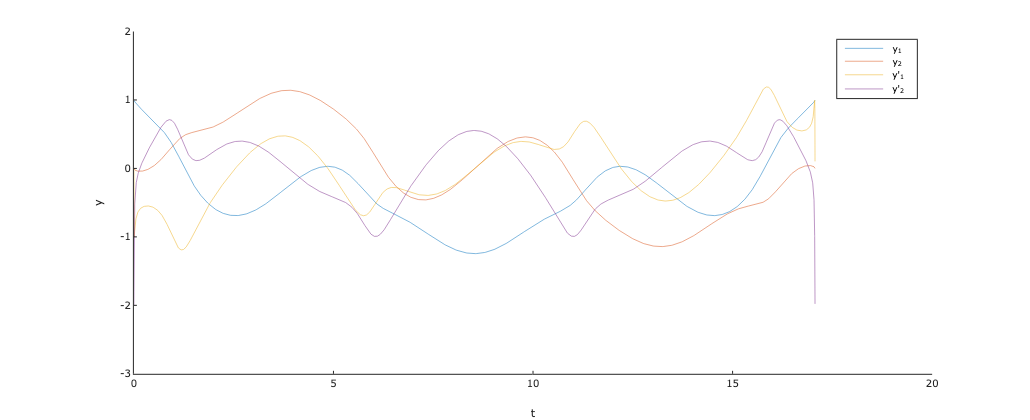

In [16]:
# Create the Arenstorf orbit problem
problem = otp.arenstorf.presets.Canonical;

# Compute the solution
sol = problem.solve('RelTol', 1e-10);

# Create solution plot
problem.plot(sol)

The `plotPhaseSpace ` function creates a phase-space diagram by visualizing all spatial-components of the state vector:

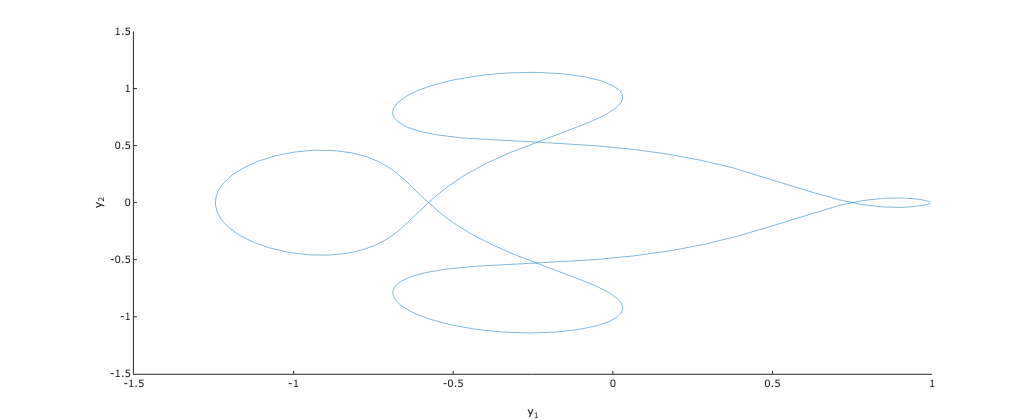

In [6]:
problem.plotPhaseSpace(sol)

## Exploring presets 

Brusselator 

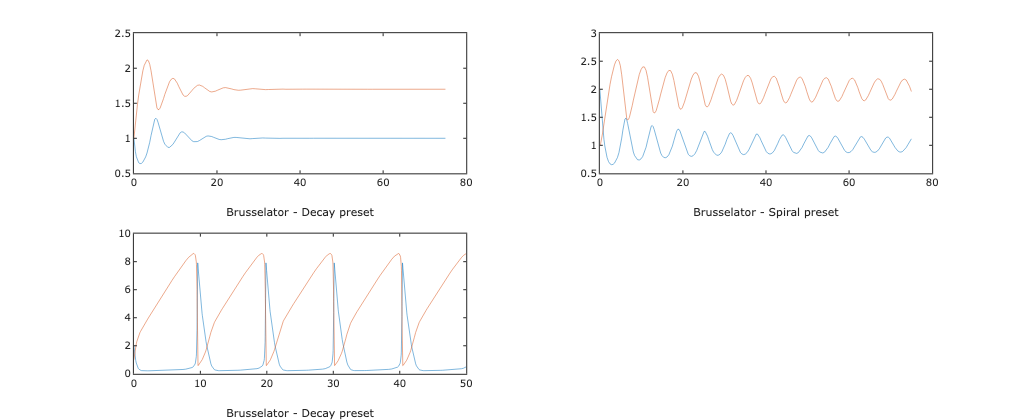

In [123]:
subplot(2,2,1);
problem = otp.brusselator.presets.Decay();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Decay preset')

subplot(2,2,2);
problem = otp.brusselator.presets.Spiral();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Spiral preset')

subplot(2,2,3);
problem = otp.brusselator.presets.Periodic();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Decay preset')

## Changing the solver

The choice of ODE solver for the test problems is flexible. Here, we will use the *Explicit* time-stepping method `ode45` to solve the Robertson problem:

In [35]:
% Create a problem object
problem          = otp.robertson.presets.Canonical();
problem.TimeSpan = [0,5];

We will pass the right-hand-side function, timespan of the integration, and the initial condition to `ode45`:

In [36]:
tic
sol = ode45(problem.RHS.F, problem.TimeSpan, problem.Y0);
toc

Elapsed time is 3.08477 seconds.


Since this is a stiff problem, the explicit solver takes a long time to finish the integration. For a faster result, we can use the *Implicit* ODE solver `ode23s` and provide it with the Jacobian of the right-hand-side: 

In [37]:
tic
sol = ode23s(problem.RHS.F, problem.TimeSpan, problem.Y0, odeset('Jacobian', problem.RHS.Jacobian));
toc

Elapsed time is 0.0469949 seconds.


# List of ODE Test Problems

You can use any of the problems using the template command

`model = otp.{problem name}.presets.{Preset name};`

Below are `{problem name}` of test problems currently implemented in `OTP`. A default `{Preset name}` for all implemented problems is `Canonical`. Other presets are specific to each test problem.

| Problem name     | Description |     | Problem name     | Description |
|:-----------------|:-----------:|-----|:-----------------|:-----------:|
| allencahn        |             |     | arenstorf        |             |
| ascherlineardae  |             |     | bouncingball     |             |
| brusselator      |             |     | cusp             |             |
| e5               |             |     | hires            |             |
| inverterchain    |             |     | kpr              |             |
| lienard          |             |     | lorenz63         |             |
| lorenz96         |             |     | lotkavolterra    |             |
| nbody            |             |     | oregonator       |             |
| pendulum         |             |     | protherorobinson |             |
| quadratic        |             |     | robertson        |             |
| sanzserna        |             |     | torus            |             |
| transistoramplifier |           |     | trigonometricdae |             |
| zlakinetics      |             |     | vanderpol        |             |
| qg               |             |     | linear           |             |
|                  |             |     |                  |             |
